## In this notebook we explore the data lightly and convert it to a processed format to be able to better work with the data.

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import collections
import os

In [2]:
processed_folder_path = os.path.join("..", "data", "processed")
unprocessed_folder_path = os.path.join("..", "data", "unprocessed")

In [3]:
def pandas_eda(df):
    print("First 5 columns")
    print(df.head())
    print("*" * 100)
    print("Dataframe information")
    print(df.info())
    print("*" * 100)
    print("Missing values")
    print(df.isnull().sum())
    print("*" * 100)

### ENSO Index

We include the ENSO index as a column denoting a wet year, dry year or normal year.

$
flag = \begin{cases}
    -1, \text{if } \text{ ENSO } < -0.5 \\
    0, \text{if } 0.5 < \text{ ENSO } < 0.5 \\
    1, \text{if } \text{ ENSO } > 0.5
\end{cases}
$

with -1 denoting a dry year, 0 denoting a normal year and 1 denoting a wet year.

In [4]:
df = pd.read_excel(os.path.join(unprocessed_folder_path, "Data_ENSO", "ENSO evolution.xlsx"), skiprows=2)

df["avg"] = df.loc[:, df.columns != "Year"].mean(axis=1)

year_data = {}

for index, row in df.iterrows():
    year, avg = row["Year"], row["avg"]
    
    # Determine "wetness" of year
    if avg < -0.5:
        index = -1
    elif -0.5 < avg < 0.5:
        index = 0
    elif avg > 0.5:
        index = 1
    
    year_data[year] = index

#### Here I plot some information about the distribution of years

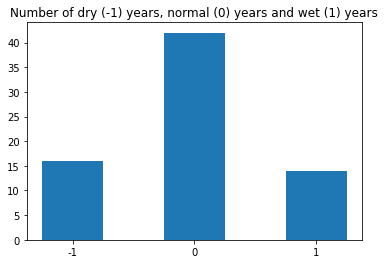

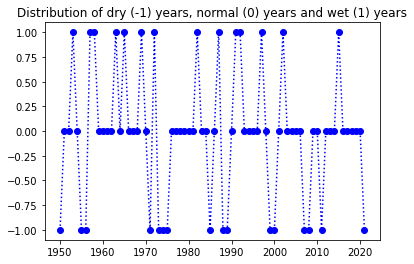

In [5]:
counter = collections.Counter(year_data.values())
labels, values = zip(*counter.items())

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width, align="edge") 
plt.title("Number of dry (-1) years, normal (0) years and wet (1) years")
plt.xticks(indexes + width * 0.5, labels)
plt.show()

plt.figure()
plt.plot(year_data.keys(), year_data.values(), 'ob:')
plt.title("Distribution of dry (-1) years, normal (0) years and wet (1) years")
plt.show()

### Convert data files from NDSI/NDVI to formatted CSVs

In [6]:
data_folder = "Data_NDSI_NDVI"
data_files = ["NDSI.txt", "NDVI.txt"]


for data_file in data_files:
    df = pd.read_csv(os.path.join(unprocessed_folder_path, data_folder, data_file), 
                     delimiter="\t", index_col=False,
                     names=["Watershed", "Subsubwatershed", "Product", "Date",
                            "Areaini", "Areareproj", "SurfNDSImax", "SurfNDSImin",
                            "SurfNDSIavg", "NDSImax", "NDSImin", "NDSIavg",
                            "Surfcloudmax", "Surfcloudmin", "Surfcloudavg",
                            "Surfbadpixmax", "Surfbadpixmin", "Surfbadpixavg"])
    df["Date"] = pd.to_datetime(df["Date"])
    # Add year_type column, determining wetness of year
    df["year_type"] = pd.DatetimeIndex(df['Date']).year.map(year_data)
    pandas_eda(df)
    df.to_csv(os.path.join(processed_folder_path, data_file[:4] + ".csv"))



First 5 columns
         Watershed  Subsubwatershed  Product       Date     Areaini  \
0  Atacama_Copiapo             3400  MOD10A1 2016-03-25  803.634365   
1  Atacama_Copiapo             3400  MOD10A1 2018-03-15  803.634365   
2  Atacama_Copiapo             3400  MOD10A1 2014-05-26  803.634365   
3  Atacama_Copiapo             3400  MOD10A1 2008-10-13  803.634365   
4  Atacama_Copiapo             3400  MOD10A1 2015-08-23  803.634365   

   Areareproj  SurfNDSImax  SurfNDSImin  SurfNDSIavg    NDSImax    NDSImin  \
0  805.586803     0.000000     0.000000     0.000000   0.000000   0.000000   
1  805.586803     0.000000     0.000000     0.000000   0.000000   0.000000   
2  805.586803   383.940650   354.708432   369.324541  52.839291  52.776429   
3  805.586803     0.000000     0.000000     0.000000   0.000000   0.000000   
4  805.586803   227.302069   201.341249   214.321659  28.252401  27.124349   

     NDSIavg  Surfcloudmax  Surfcloudmin  Surfcloudavg  Surfbadpixmax  \
0   0.000000   

### Convert data from the river flow dataset to properly formatted CSV

In [7]:
flow_data_folder = "Data_RiverFlow"
flow_data_file = "DGA.txt"

date_columns = ["day", "month", "year", "hour"]

df = pd.read_csv(os.path.join(unprocessed_folder_path, flow_data_folder, flow_data_file), 
                 delimiter="\t", index_col=False,
                 names=["station_number", "day", "month", "year", "hour", 
                        "river_height", "river_flow", "information", "origin"])

# Convert date go datetime and add as column
date = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day, hour=df.hour))
df = df.drop(columns=date_columns)
df.insert(1, 'date', date)

# Add year_type column, determining wetness of year
df["year_type"] = pd.DatetimeIndex(df['date']).year.map(year_data)

df.to_csv(os.path.join(processed_folder_path, flow_data_file[:3] + ".csv"))

## Plot data density

### NDSI and NDVI data density given time

In [8]:
df_NDSI = pd.read_csv(os.path.join(processed_folder_path, "NDSI.csv"), index_col=0)
df_NDVI = pd.read_csv(os.path.join(processed_folder_path, "NDSI.csv"), index_col=0)

In [9]:
def plot_data_density(dfs, labels):
    plt.figure(figsize=(14, 8))
    for df, label in zip(dfs, labels):
        plt.plot(df.groupby(["year"]).size(), label=label)
    
    plt.title("Frequency of years in data")
    plt.xlabel("Year")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    for df, label in zip(dfs, labels):
        plt.plot(df.groupby(["month"]).size(), label=label)

    plt.xticks(range(12), range(1, 13))
    plt.title("Frequency of months in data")
    plt.xlabel("Month")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

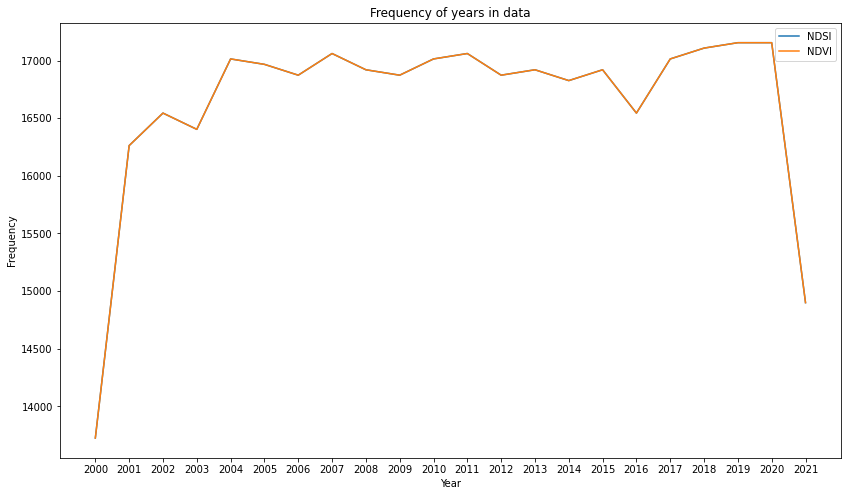

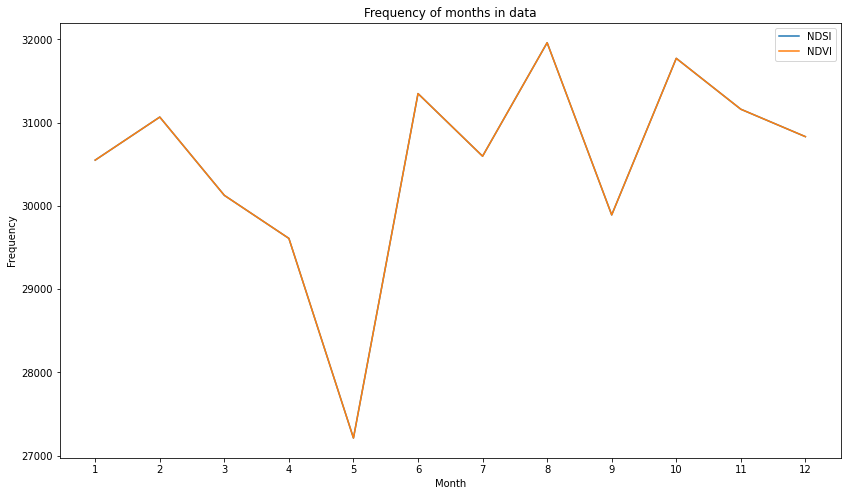

In [10]:
df_NDSI["Date"] = pd.to_datetime(df_NDSI["Date"])
df_NDSI["year"] = df_NDSI["Date"].apply(lambda x: "%d" % (x.year))
df_NDSI["month"] = df_NDSI["Date"].apply(lambda x: "%d" % (x.month)) 

df_NDVI["Date"] = pd.to_datetime(df_NDVI["Date"])
df_NDVI["year"] = df_NDSI["Date"].apply(lambda x: "%d" % (x.year))
df_NDVI["month"] = df_NDSI["Date"].apply(lambda x: "%d" % (x.month)) 

plot_data_density([df_NDSI, df_NDVI], ["NDSI", "NDVI"])

### DGA data density given time 

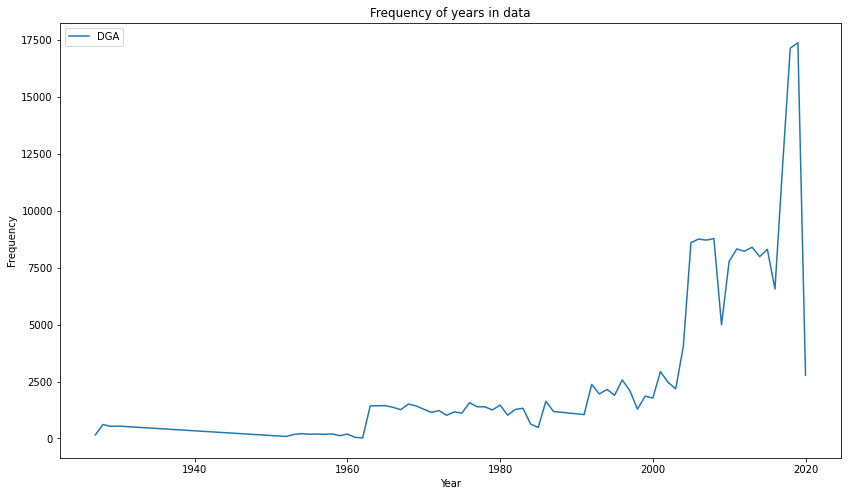

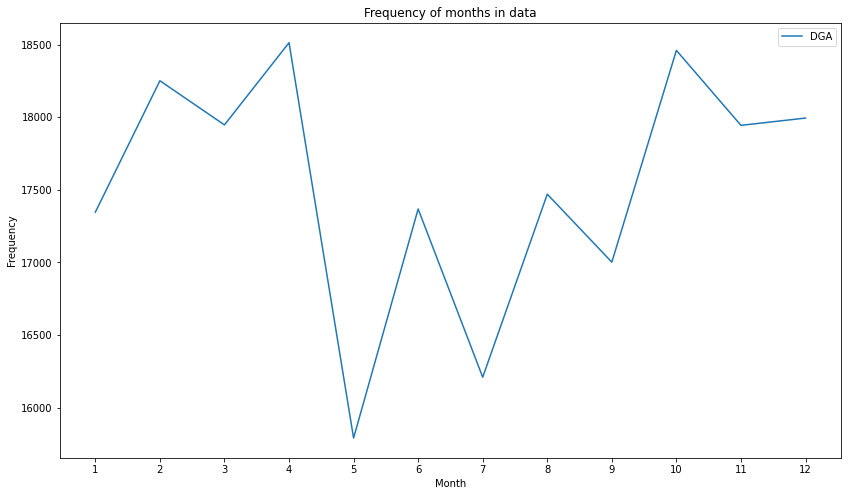

In [11]:
df_DGA = pd.read_csv(os.path.join(processed_folder_path, "DGA.csv"), index_col=0)

df_DGA["date"] = pd.to_datetime(df_DGA["date"])

df_DGA["year"] = df_DGA["date"].apply(lambda x: "%d" % (x.year))
df_DGA["month"] = df_DGA["date"].apply(lambda x: "%d" % (x.month)) 

df_DGA["year"] = df_DGA["year"].astype(int)

plot_data_density([df_DGA], ["DGA"])